# Video prediction with SAM 3

## 1. Setup

In [1]:
sam3_root = "/home/ronghanghu/workspace/sam3"
bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"

# # prod v12 model (s3://fb-fair-onevision/ronghanghu/sam3_release/ckpts/prod_v12_sam2_internal_shared_dth0.5_newdet0.7_assth0.1_nms0.1.pt)
# checkpoint_file = "/checkpoint/sam3/ronghanghu/sam3_release/ckpts/prod_v12_sam2_internal_shared_dth0.5_newdet0.7_assth0.1_nms0.1.pt"
# has_presence_token = False
# geo_encoder_use_img_cross_attn = False

# prod v14 model (s3://fb-fair-onevision/ronghanghu/sam3_release/ckpts/sam3_v14_rc1.pt)
checkpoint_file = "/checkpoint/sam3/ronghanghu/sam3_release/ckpts/sam3_v14_rc1.pt"
has_presence_token = True
geo_encoder_use_img_cross_attn = True

In [2]:
import torch

# use all available GPUs on the machine
gpus_to_use = range(torch.cuda.device_count())

# # use only a single GPU
# gpus_to_use = [torch.cuda.current_device()]

In [3]:
from sam3.model.sam3_video_predictor import Sam3VideoPredictorMultiGPU

predictor = Sam3VideoPredictorMultiGPU(
    bpe_path=bpe_path,
    checkpoint_path=checkpoint_file,
    has_presence_token=has_presence_token,
    geo_encoder_use_img_cross_attn=geo_encoder_use_img_cross_attn,
    strict_state_dict_loading=True,
    gpus_to_use=gpus_to_use,
)

Enabled the use of perflib.


INFO 2025-10-02 07:16:56,610 1040920 sam3_video_predictor.py: 285: using the following GPU IDs: [0, 1, 2, 3, 4, 5, 6, 7]
INFO 2025-10-02 07:16:56,611 1040920 sam3_video_predictor.py: 301: 


	*** START loading model on all ranks ***


INFO 2025-10-02 07:16:56,611 1040920 sam3_video_predictor.py: 303: loading model on rank=0 with world_size=8 -- this could take a while ...
INFO 2025-10-02 07:17:03,964 1040920 sam3_video_base.py: 307: `setting max_num_objects` to 128 -- creating num_obj_for_compile=16 objects for torch.compile cache
INFO 2025-10-02 07:17:07,351 1040920 sam3_video_predictor.py: 305: loading model on rank=0 with world_size=8 -- DONE locally
INFO 2025-10-02 07:17:07,352 1040920 sam3_video_predictor.py: 362: spawning 7 worker processes


Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.


INFO 2025-10-02 07:17:14,501 1041088 sam3_video_predictor.py: 442: starting worker process rank=5 with world_size=8
INFO 2025-10-02 07:17:15,254 1041090 sam3_video_predictor.py: 442: starting worker process rank=7 with world_size=8
INFO 2025-10-02 07:17:15,619 1041086 sam3_video_predictor.py: 442: starting worker process rank=3 with world_size=8
INFO 2025-10-02 07:17:15,768 1041088 sam3_video_predictor.py: 303: loading model on rank=5 with world_size=8 -- this could take a while ...
INFO 2025-10-02 07:17:15,859 1041089 sam3_video_predictor.py: 442: starting worker process rank=6 with world_size=8
INFO 2025-10-02 07:17:15,896 1041087 sam3_video_predictor.py: 442: starting worker process rank=4 with world_size=8
INFO 2025-10-02 07:17:16,115 1041084 sam3_video_predictor.py: 442: starting worker process rank=1 with world_size=8
INFO 2025-10-02 07:17:16,227 1041085 sam3_video_predictor.py: 442: starting worker process rank=2 with world_size=8
INFO 2025-10-02 07:17:16,441 1041090 sam3_video_

NCCL version 2.25.1+cuda12.6

h100-021-175:1041087:1042179 [4] graph/xml.cc:378 NCCL WARN Could not open XML topology file /data/home/ronghanghu/anaconda3/envs/onevision_sam3/share/aws-ofi-nccl/xml/p5.48xl-topo.xml : No such file or directory

h100-021-175:1040920:1042165 [0] graph/xml.cc:378 NCCL WARN Could not open XML topology file /data/home/ronghanghu/anaconda3/envs/onevision_sam3/share/aws-ofi-nccl/xml/p5.48xl-topo.xml : No such file or directory

h100-021-175:1041085:1042167 [2] graph/xml.cc:378 NCCL WARN Could not open XML topology file /data/home/ronghanghu/anaconda3/envs/onevision_sam3/share/aws-ofi-nccl/xml/p5.48xl-topo.xml : No such file or directory

h100-021-175:1041089:1042173 [6] graph/xml.cc:378 NCCL WARN Could not open XML topology file /data/home/ronghanghu/anaconda3/envs/onevision_sam3/share/aws-ofi-nccl/xml/p5.48xl-topo.xml : No such file or directory

h100-021-175:1041086:1042171 [3] graph/xml.cc:378 NCCL WARN Could not open XML topology file /data/home/ronghanghu

INFO 2025-10-02 07:19:02,450 1040920 sam3_video_predictor.py: 415: started NCCL process group on rank=0 with world_size=8
INFO 2025-10-02 07:19:02,450 1041088 sam3_video_predictor.py: 415: started NCCL process group on rank=5 with world_size=8
INFO 2025-10-02 07:19:02,450 1041086 sam3_video_predictor.py: 415: started NCCL process group on rank=3 with world_size=8
INFO 2025-10-02 07:19:02,450 1041089 sam3_video_predictor.py: 415: started NCCL process group on rank=6 with world_size=8
INFO 2025-10-02 07:19:02,450 1041085 sam3_video_predictor.py: 415: started NCCL process group on rank=2 with world_size=8
INFO 2025-10-02 07:19:02,450 1041087 sam3_video_predictor.py: 415: started NCCL process group on rank=4 with world_size=8
INFO 2025-10-02 07:19:02,450 1041084 sam3_video_predictor.py: 415: started NCCL process group on rank=1 with world_size=8
INFO 2025-10-02 07:19:02,450 1041090 sam3_video_predictor.py: 415: started NCCL process group on rank=7 with world_size=8
INFO 2025-10-02 07:19:02

### Visualization utils

In [4]:
import os
import glob
import matplotlib.pyplot as plt
from utils import visualize_formatted_frame_output, prepare_masks_for_visualization

Converting 5000 RGB samples to LAB color space...
Conversion to LAB complete.
Fitting KMeans with 128 clusters on 5000 samples...
KMeans fitting complete.


## 2. Running inference

In [5]:
# this video has 6 objects
video_frames_dir = f"{sam3_root}/assets/videos/0001"
prompt_text_str = "person"

# this video has ~80 objects
# video_frames_dir = "/checkpoint/sam3/shared/webdemo/data/ta/static/gallery/selected_examples/0018/rgb"
# prompt_text_str = "horse"

In [6]:
# load "image_files" for visualization purposes (they are not used by the model)
image_files = glob.glob(os.path.join(video_frames_dir, "*.jpg"))
try:
    # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
    image_files.sort(key=lambda p: int(os.path.splitext(os.path.basename(p))[0]))
except ValueError:
    # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
    print(
        f'frame names are not in "<frame_index>.jpg" format: {image_files[:5]=}, '
        f"falling back to lexicographic sort."
    )
    image_files.sort()

### Opening an inference session on this video

In [7]:
response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_frames_dir,
    )
)
session_id = response["session_id"]

INFO 2025-10-02 07:19:05,691 1041084 sam3_video_predictor.py: 471: worker rank=1 received request request['type']='start_session'
INFO 2025-10-02 07:19:05,691 1041085 sam3_video_predictor.py: 471: worker rank=2 received request request['type']='start_session'
INFO 2025-10-02 07:19:05,691 1041086 sam3_video_predictor.py: 471: worker rank=3 received request request['type']='start_session'
INFO 2025-10-02 07:19:05,691 1041087 sam3_video_predictor.py: 471: worker rank=4 received request request['type']='start_session'
INFO 2025-10-02 07:19:05,691 1041088 sam3_video_predictor.py: 471: worker rank=5 received request request['type']='start_session'
INFO 2025-10-02 07:19:05,692 1041089 sam3_video_predictor.py: 471: worker rank=6 received request request['type']='start_session'
INFO 2025-10-02 07:19:05,692 1041090 sam3_video_predictor.py: 471: worker rank=7 received request request['type']='start_session'
frame loading (JPEG) [rank=0]:   0%|                                                      

### Adding a text prompt on frame 0 and propagation throughout the video

Note that the first call might be slower due to setting up buffers. **You can rerun all the cells below when measuring speed.**

In [8]:
# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

INFO 2025-10-02 07:19:06,460 1040920 sam3_video_predictor.py: 216: clear all inputs across the video in session 7fb3be09-5078-4bb4-b052-670d09131f6c
INFO 2025-10-02 07:19:06,460 1041084 sam3_video_predictor.py: 471: worker rank=1 received request request['type']='reset_session'
INFO 2025-10-02 07:19:06,460 1041085 sam3_video_predictor.py: 471: worker rank=2 received request request['type']='reset_session'
INFO 2025-10-02 07:19:06,460 1041084 sam3_video_predictor.py: 216: clear all inputs across the video in session 7fb3be09-5078-4bb4-b052-670d09131f6c
INFO 2025-10-02 07:19:06,460 1041086 sam3_video_predictor.py: 471: worker rank=3 received request request['type']='reset_session'
INFO 2025-10-02 07:19:06,460 1041088 sam3_video_predictor.py: 471: worker rank=5 received request request['type']='reset_session'
INFO 2025-10-02 07:19:06,460 1041087 sam3_video_predictor.py: 471: worker rank=4 received request request['type']='reset_session'
INFO 2025-10-02 07:19:06,460 1041088 sam3_video_pred

In [9]:
frame_idx = 0  # add a text prompt on frame 0
response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
out = response["outputs"]

INFO 2025-10-02 07:19:07,954 1040920 sam3_video_predictor.py: 141: add prompt on frame 0 in session 7fb3be09-5078-4bb4-b052-670d09131f6c: text='person', points=None, point_labels=None, clear_old_points=True, bounding_boxes=None, bounding_box_labels=None, clear_old_boxes=True
INFO 2025-10-02 07:19:07,955 1041086 sam3_video_predictor.py: 471: worker rank=3 received request request['type']='add_prompt'
INFO 2025-10-02 07:19:07,955 1041090 sam3_video_predictor.py: 471: worker rank=7 received request request['type']='add_prompt'
INFO 2025-10-02 07:19:07,955 1041086 sam3_video_predictor.py: 141: add prompt on frame 0 in session 7fb3be09-5078-4bb4-b052-670d09131f6c: text='person', points=None, point_labels=None, clear_old_points=True, bounding_boxes=None, bounding_box_labels=None, clear_old_boxes=True
INFO 2025-10-02 07:19:07,955 1041090 sam3_video_predictor.py: 141: add prompt on frame 0 in session 7fb3be09-5078-4bb4-b052-670d09131f6c: text='person', points=None, point_labels=None, clear_old

frame loading (JPEG) [rank=7]: 100%|██████████| 270/270 [00:12<00:00, 20.80it/s]


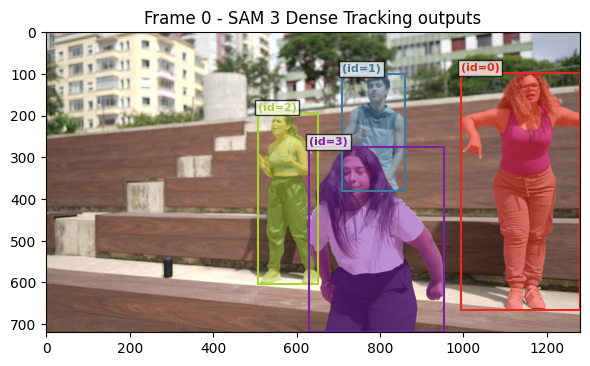

In [10]:
plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    image_files,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

In [11]:
# we will just propagate from frame 0 to the end of the video
outputs_per_frame = {}
for response in predictor.handle_stream_request(
    request=dict(
        type="propagate_in_video",
        session_id=session_id,
    )
):
    outputs_per_frame[response["frame_index"]] = response["outputs"]

outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

INFO 2025-10-02 07:19:19,599 1040920 sam3_video_predictor.py: 175: propagate in video in session 7fb3be09-5078-4bb4-b052-670d09131f6c: propagation_direction='both', start_frame_idx=None, max_frame_num_to_track=None
INFO 2025-10-02 07:19:19,600 1041084 sam3_video_predictor.py: 471: worker rank=1 received request request['type']='propagate_in_video'
INFO 2025-10-02 07:19:19,600 1041085 sam3_video_predictor.py: 471: worker rank=2 received request request['type']='propagate_in_video'
INFO 2025-10-02 07:19:19,600 1041084 sam3_video_predictor.py: 175: propagate in video in session 7fb3be09-5078-4bb4-b052-670d09131f6c: propagation_direction='both', start_frame_idx=None, max_frame_num_to_track=None
INFO 2025-10-02 07:19:19,600 1041086 sam3_video_predictor.py: 471: worker rank=3 received request request['type']='propagate_in_video'
INFO 2025-10-02 07:19:19,600 1041085 sam3_video_predictor.py: 175: propagate in video in session 7fb3be09-5078-4bb4-b052-670d09131f6c: propagation_direction='both', 

propagate_in_video:   0%|          | 0/270 [00:00<?, ?it/s]

INFO 2025-10-02 07:19:28,334 1041089 sam3_video_predictor.py: 210: propagation ended in session 7fb3be09-5078-4bb4-b052-670d09131f6c; live sessions: ['7fb3be09-5078-4bb4-b052-670d09131f6c' (270 frames)], GPU memory: 5573 MiB used and 7754 MiB reserved (max over time: 7336 MiB used and 7754 MiB reserved)
INFO 2025-10-02 07:19:28,334 1041090 sam3_video_predictor.py: 210: propagation ended in session 7fb3be09-5078-4bb4-b052-670d09131f6c; live sessions: ['7fb3be09-5078-4bb4-b052-670d09131f6c' (270 frames)], GPU memory: 5571 MiB used and 7776 MiB reserved (max over time: 7336 MiB used and 7776 MiB reserved)
INFO 2025-10-02 07:19:28,337 1041087 sam3_video_predictor.py: 210: propagation ended in session 7fb3be09-5078-4bb4-b052-670d09131f6c; live sessions: ['7fb3be09-5078-4bb4-b052-670d09131f6c' (270 frames)], GPU memory: 5683 MiB used and 7884 MiB reserved (max over time: 7488 MiB used and 7884 MiB reserved)
INFO 2025-10-02 07:19:28,337 1041084 sam3_video_predictor.py: 210: propagation ended 

propagate_in_video: 0it [00:00, ?it/s]

INFO 2025-10-02 07:19:28,398 1040920 sam3_video_predictor.py: 210: propagation ended in session 7fb3be09-5078-4bb4-b052-670d09131f6c; live sessions: ['7fb3be09-5078-4bb4-b052-670d09131f6c' (270 frames)], GPU memory: 8547 MiB used and 11196 MiB reserved (max over time: 10264 MiB used and 11196 MiB reserved)


frame 0


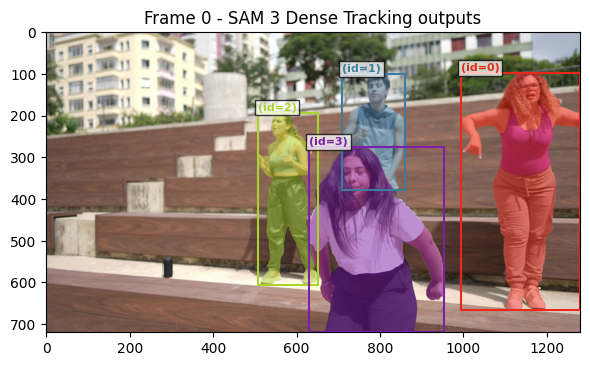

frame 60


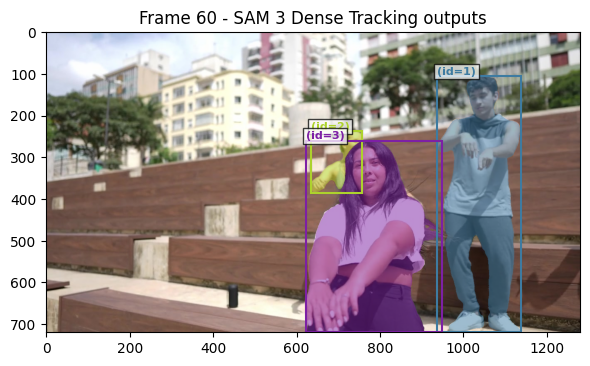

frame 120


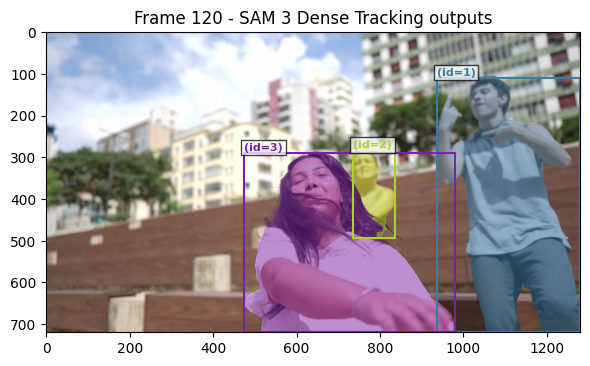

frame 180


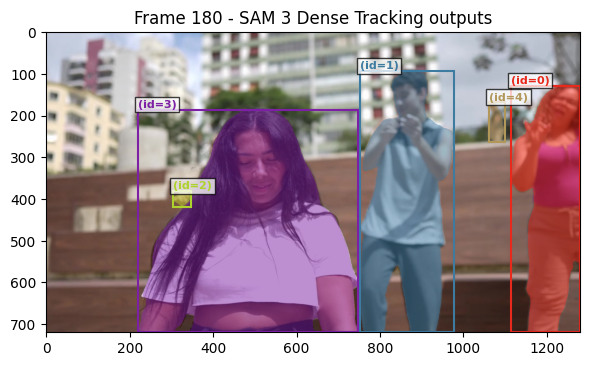

frame 240


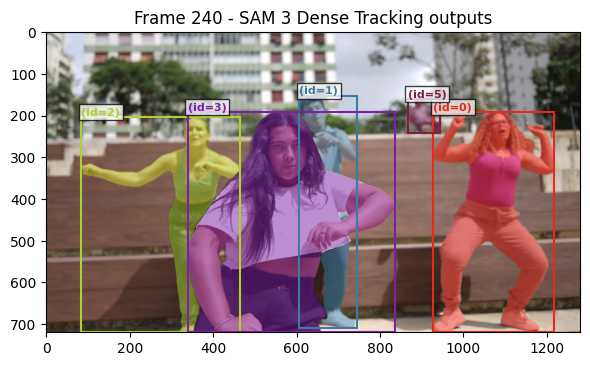

In [12]:
vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    print(f"frame {frame_idx}")
    visualize_formatted_frame_output(
        frame_idx,
        image_files,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

In [13]:
# finally, close the inference session to free its GPU resources
# (you may start a new session on another video)
_ = predictor.handle_request(
    request=dict(
        type="close_session",
        session_id=session_id,
    )
)

INFO 2025-10-02 07:19:31,295 1041089 sam3_video_predictor.py: 471: worker rank=6 received request request['type']='close_session'
INFO 2025-10-02 07:19:31,295 1041087 sam3_video_predictor.py: 471: worker rank=4 received request request['type']='close_session'
INFO 2025-10-02 07:19:31,296 1041088 sam3_video_predictor.py: 471: worker rank=5 received request request['type']='close_session'
INFO 2025-10-02 07:19:31,296 1041084 sam3_video_predictor.py: 471: worker rank=1 received request request['type']='close_session'
INFO 2025-10-02 07:19:31,296 1041086 sam3_video_predictor.py: 471: worker rank=3 received request request['type']='close_session'
INFO 2025-10-02 07:19:31,296 1041090 sam3_video_predictor.py: 471: worker rank=7 received request request['type']='close_session'
INFO 2025-10-02 07:19:31,297 1041085 sam3_video_predictor.py: 471: worker rank=2 received request request['type']='close_session'
INFO 2025-10-02 07:19:31,475 1041088 sam3_video_predictor.py: 236: removed session 7fb3be0

## 3. Clean up

In [14]:
# after all inference is done, we can shutdown the predictor
# to free up the multi-GPU process group
predictor.shutdown()

INFO 2025-10-02 07:19:31,585 1040920 sam3_video_predictor.py: 494: shutting down 7 worker processes
INFO 2025-10-02 07:19:31,586 1041087 sam3_video_predictor.py: 466: worker rank=4 shutting down
INFO 2025-10-02 07:19:31,586 1041090 sam3_video_predictor.py: 466: worker rank=7 shutting down
INFO 2025-10-02 07:19:31,586 1041084 sam3_video_predictor.py: 466: worker rank=1 shutting down
INFO 2025-10-02 07:19:31,586 1041085 sam3_video_predictor.py: 466: worker rank=2 shutting down
INFO 2025-10-02 07:19:31,586 1041088 sam3_video_predictor.py: 466: worker rank=5 shutting down
INFO 2025-10-02 07:19:31,587 1041089 sam3_video_predictor.py: 466: worker rank=6 shutting down
INFO 2025-10-02 07:19:31,587 1041086 sam3_video_predictor.py: 466: worker rank=3 shutting down
INFO 2025-10-02 07:19:32,200 1040920 sam3_video_predictor.py: 500: shut down 7 worker processes
